In [67]:
import warnings
warnings.filterwarnings('ignore')
    # Supresses Neural Net Warning "ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached
        # and the optimization hasn't converged yet."
    # Supresses QDA Warning "UserWarning: Variables are collinear"

In [68]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process.kernels import RBF

In [69]:
# For Numeric and Ordinal values, NOTHING is done, for Categorical values, they are converted to Ordinal values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html
def preprocessData(dataFrame: pd.DataFrame, columnsToProcess: list) -> np.array:
    tempData = []
    enc = preprocessing.OrdinalEncoder()

    for col in columnsToProcess:
        if (col[1] == 'C'):
            tempDataArray = enc.fit_transform(dataFrame[[col[0]]])
            for i in range(np.shape(tempDataArray)[1]):
                tempData.append(tempDataArray[:, i])
        else:
            tempData.append(dataFrame[col[0]].values)
    
    return np.stack(tempData, axis=1)

In [70]:
#Will ONLY work if the model has a predict function
def getPredictions(model, passengerIDsColumn: pd.Series, dataArrayToPredict: np.array) -> pd.DataFrame:
    results = []
    for i in range(len(dataArrayToPredict)):
        results.append(model.predict([dataArrayToPredict[i,:]])[0])
    return pd.concat([passengerIDsColumn, pd.DataFrame({'Survived' : results})], axis=1)

In [71]:
trainData = pd.read_csv('./titanic/train.csv',
    usecols=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
             'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Survived' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float,
           'SibSp' : int, 'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)
testData = pd.read_csv('./titanic/test.csv',
    usecols=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
    dtype={'PassengerId' : int, 'Pclass' : int, 'Name' : str, 'Sex' : str, 'Age' : float, 'SibSp' : int,
           'Parch' : int, 'Ticket' : str, 'Fare' : float, 'Cabin' : str, 'Embarked' : str}
)

In [72]:
# copy of datasets, originals may be needed for reference
trainCopy = trainData.copy(deep = True)
testCopy = testData.copy(deep = True)
datasets = [trainCopy, testCopy]

In [101]:
# find incomplete columns
print("Sums of incomplete TRAINING values:")
print(datasets[0].isnull().sum())
print("------------------------------")
print("Sums of incomplete TEST values:")
print(datasets[1].isnull().sum())

Sums of incomplete TRAINING values:
PassengerId              0
Survived                 0
Pclass                   0
Name                     0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                  687
Embarked                 0
Title                    0
FamilySize               0
AgeClassInteraction      0
FareBin                  0
AgeBin                   0
Sex_Code                 0
Embarked_Code            0
Title_Code               0
AgeBin_Code              0
FareBin_Code             0
dtype: int64
------------------------------
Sums of incomplete TEST values:
PassengerId              0
Pclass                   0
Name                     0
Sex                      0
Age                      0
SibSp                    0
Parch                    0
Ticket                   0
Fare                     0
Cabin                  327
Embarked                

In [74]:
# since Name is a complete feature, we will use it to engineer the "Title" feature
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [75]:
print("Titles in TRAIN:")
print(datasets[0]['Title'].value_counts())
print("-------------------")
print("Titles in TEST:")
print(datasets[1]['Title'].value_counts())

Titles in TRAIN:
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64
-------------------
Titles in TEST:
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


In [76]:
# replace "rare" (fewer than 10 instances) and foreign titles with english equivalent
for dataset in datasets:
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 
                                                'Sir', 'Jonkheer', 'Dona'], 
                                                'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [77]:
print("Titles in TRAIN:")
print(datasets[0]['Title'].value_counts())
print("-------------------")
print("Titles in TEST:")
print(datasets[1]['Title'].value_counts())

Titles in TRAIN:
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64
-------------------
Titles in TEST:
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64


In [99]:
# now that we have the Title attribute, we will complete the Age feature using the
# median age associated with each title, and complete the rest of the features
for dataset in datasets:
    dataset['Age'] = dataset.groupby('Title', as_index = True)['Age'].apply(lambda age: age.fillna(age.median()))
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

In [79]:
# Feature Engineering
    # FamilySize = siblings + spouse + parents + children
    # AgeClassInteraction = product of age and passenger class
for dataset in datasets:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['AgeClassInteraction'] = dataset['Age'] * dataset['Pclass']

In [102]:
# data discretization and categorical encoding
label = preprocessing.LabelEncoder()
for dataset in datasets:  
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 7)
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [103]:
pd.cut(trainCopy['Age'], 7)

0      (11.789, 23.157]
1      (34.526, 45.894]
2      (23.157, 34.526]
3      (34.526, 45.894]
4      (34.526, 45.894]
             ...       
886    (23.157, 34.526]
887    (11.789, 23.157]
888    (11.789, 23.157]
889    (23.157, 34.526]
890    (23.157, 34.526]
Name: Age, Length: 891, dtype: category
Categories (7, interval[float64, right]): [(0.34, 11.789] < (11.789, 23.157] < (23.157, 34.526] < (34.526, 45.894] < (45.894, 57.263] < (57.263, 68.631] < (68.631, 80.0]]

In [82]:
# Determine Columns to Use
    # List of columns to use in creating the model and the data type
    #   'C' - Categorical
    #   'N' - Numeric
    #   'O' - Ordinal
colList = [('Pclass', 'O'), ('Sex', 'C'), ('Age', 'N'), ('SibSp', 'N'), ('Parch', 'N'), ('Fare', 'N'),
           ('Embarked', 'C'), ('Title', 'C'), ('FamilySize', 'N'), ('AgeClassInteraction', 'N')]

#            ,('AgeBin', 'C'), , ('Embarked_Code', 'C'), ('Title_Code', 'C'), ('AgeBin_Code', 'C'),
#            ('FareBin_Code', 'C')


In [83]:
# Preprocess Data
preprocessedDatasets = [preprocessData(dataset, colList) for dataset in datasets]

In [84]:
# Create Model(s) #########################################
    # Inspiration for Classifier Models was taken from the following page
    # https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
classifiers = [
    ("Default Nearest Neighbors", KNeighborsClassifier()),
    ("10 Nearest Neighbors (Brute)", KNeighborsClassifier(n_neighbors=10, algorithm='brute')),
    ("SVM", SVC()),
    ("Gaussian Process", GaussianProcessClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Neural Net", MLPClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("QDA", QuadraticDiscriminantAnalysis()),
]

models = []
for i in range(len(classifiers)):
    models.append((classifiers[i][0], classifiers[i][1].fit(preprocessedDatasets[0], datasets[0]['Survived'])))

In [85]:
# Get Predictions
summaryDF = testData[['PassengerId']].copy(deep=True)
resultDFs = [] # List of tuples of Model name, [0], and resulting dataframe (columns PassengerId and Survived), [1]

for model in models:
    resultDFs.append((model[0], getPredictions(model[1], testData['PassengerId'], preprocessedDatasets[1])))
    summaryDF[model[0]] = resultDFs[-1][1]['Survived']

In [86]:
print(summaryDF.head(10))

   PassengerId  Default Nearest Neighbors  10 Nearest Neighbors (Brute)  SVM  \
0          892                          0                             0    0   
1          893                          0                             0    0   
2          894                          0                             0    0   
3          895                          1                             0    0   
4          896                          0                             0    0   
5          897                          1                             0    0   
6          898                          0                             0    0   
7          899                          0                             0    0   
8          900                          0                             0    0   
9          901                          0                             0    0   

   Gaussian Process  Decision Tree  Random Forest  Neural Net  AdaBoost  \
0                 0              0          

In [98]:
print('Scoring Models:')
results = []
for classifier in classifiers:
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = 0)
    cv_results = model_selection.cross_validate(classifier[1], preprocessedDatasets[0], trainCopy['Survived'],
                    cv  = cv_split, return_estimator=True)
    results.append(cv_results)
    score = cv_results['test_score'].max()
    print('    ' + classifier[0] + ': ' + str(score))

Scoring Models:
    Default Nearest Neighbors: 0.7486033519553073
    10 Nearest Neighbors (Brute): 0.7374301675977654
    SVM: 0.770949720670391
    Gaussian Process: 0.770949720670391
    Decision Tree: 0.8324022346368715
    Random Forest: 0.8659217877094972
    Neural Net: 0.8268156424581006
    AdaBoost: 0.8770949720670391
    Naive Bayes: 0.8491620111731844
    QDA: 0.7541899441340782


In [53]:
ada_boost_predictions = results[7]['estimator'][8].fit(preprocessedDatasets[0], trainCopy['Survived']).predict(preprocessedDatasets[0])

Confusion matrix, without normalization
[[488  61]
 [ 80 262]]
Normalized confusion matrix
[[0.89 0.11]
 [0.23 0.77]]


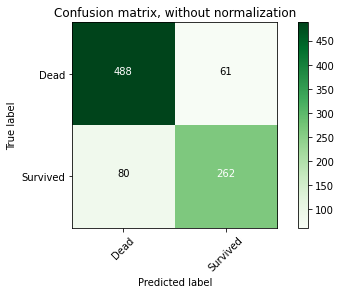

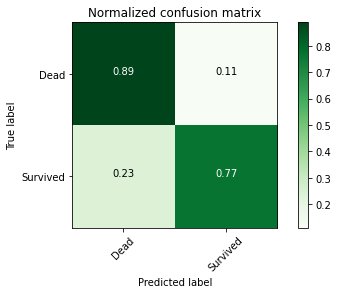

In [51]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(trainCopy['Survived'], ada_boost_predictions)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [28]:
# Uncomment to save .csv of all results
#summaryDF.to_csv(path_or_buf='modelSummary ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

In [29]:
# Result DataFrame to .csv for Kaggle Submission
# Uncomment and specify classifier number to use to save to .csv
#resultDFs['Insert Classifier Number'][1].to_csv(path_or_buf='kaggle_submission ' + datetime.datetime.now().strftime("%Y-%m-%d at %H.%M.%S") + '.csv', header=True, index=False, mode='w')

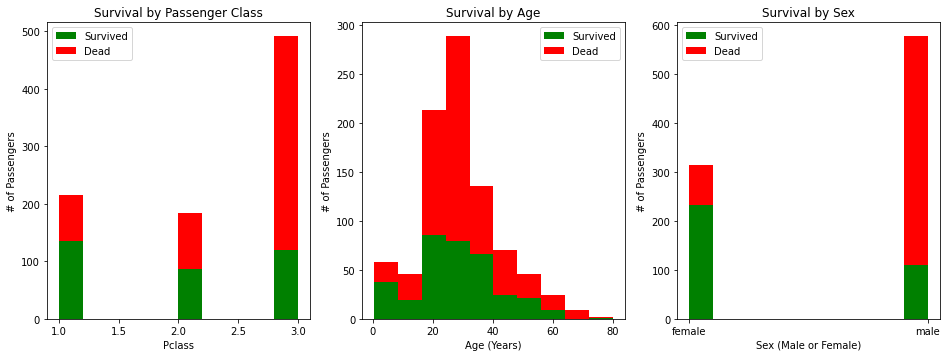

In [33]:
plt.figure(figsize=[16,12])

plt.subplot(234)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Pclass'], trainCopy[trainCopy['Survived']==0]['Pclass']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Passenger Class')
plt.xlabel('Pclass')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Age'], trainCopy[trainCopy['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Age')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [trainCopy[trainCopy['Survived']==1]['Sex'], trainCopy[trainCopy['Survived']==0]['Sex']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Survival by Sex')
plt.xlabel('Sex (Male or Female)')
plt.ylabel('# of Passengers')
plt.legend()